<a href="https://colab.research.google.com/github/gromdimon/code/blob/main/Calculating_Lipinsky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **In this part i will calculate Lipinsky descriptor using data 'Beta amyloid'.**

# Install data

In [4]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-07-21 08:24:28--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   147MB/s    in 0.6s    

2021-07-21 08:24:29 (147 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ | / - \ | / - \ | / failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / - \ | / - \ | / 

In [39]:
! wget https://github.com/gromdimon/Files/raw/main/bioactivity_with_class.csv

--2021-07-21 08:46:48--  https://github.com/gromdimon/Files/raw/main/bioactivity_with_class.csv
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gromdimon/Files/main/bioactivity_with_class.csv [following]
--2021-07-21 08:46:48--  https://raw.githubusercontent.com/gromdimon/Files/main/bioactivity_with_class.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80244 (78K) [text/plain]
Saving to: ‘bioactivity_with_class.csv’

bioactivity_with_cl 100%[===================>]  78.36K  --.-KB/s    in 0.009s  

2021-07-21 08:46:49 (8.85 MB/s) - ‘bioactivity_with_class.csv’ saved [80244/80244]



In [40]:
act = pd.read_csv('bioactivity_with_class.csv')
act

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.0,active
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.0,active
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.0,active
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.0,intermediate
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.0,active
...,...,...,...,...
924,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,300000.0,inactive
925,CHEMBL1091513,O=S(=O)(NC1CCC(c2cc(F)ccc2F)(S(=O)(=O)c2ccc(Cl...,0.5,active
926,CHEMBL4558518,CC(C)(C)OC(=O)N1CCCC1CNC1CCC(c2cc(F)ccc2F)(S(=...,1600.0,active
927,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,31.0,active


In [41]:
act_nosmiles = act.drop(columns='canonical_smiles')
smiles = []

for i in act.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')
act_clean_smiles = pd.concat([act_nosmiles,smiles], axis=1)
act_clean_smiles

,molecule_chembl_id,standard_value,bioactivity_class,canonical_smiles
0,CHEMBL311039,5000.0,active,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1
1,CHEMBL450926,2700.0,active,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1
2,CHEMBL310242,1800.0,active,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...
3,CHEMBL74874,11000.0,intermediate,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...
4,CHEMBL75183,10000.0,active,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...
...,...,...,...,...
924,CHEMBL6246,300000.0,inactive,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23
925,CHEMBL1091513,0.5,active,O=S(=O)(NC1CCC(c2cc(F)ccc2F)(S(=O)(=O)c2ccc(Cl...
926,CHEMBL4558518,1600.0,active,CC(C)(C)OC(=O)N1CCCC1CNC1CCC(c2cc(F)ccc2F)(S(=...
927,CHEMBL3609637,31.0,active,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...


In [42]:
def lipinski(smiles, verbose = False):
  moldata = []
  for elem in smiles:
    mol = Chem.MolFromSmiles(elem)
    moldata.append(mol)

  basedata = np.arange(1,1)
  i = 0
  for mol in moldata:
    desc_MolWt = Descriptors.MolWt(mol)
    desc_MolLogP = Descriptors.MolLogP(mol)
    desc_NumHDonors = Lipinski.NumHDonors(mol)
    desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
    row = np.array([desc_MolWt, desc_MolLogP, desc_NumHDonors, desc_NumHAcceptors])

    if (i==0):
      basedata = row
    else:
      basedata = np.vstack([basedata, row])
    i += 1
  columnNames = ['MW', 'LogP', 'NumHDon', 'NumHAcc']   
  descriptors = pd.DataFrame(data = basedata, columns = columnNames)

  return descriptors

In [43]:
act_lipinski = lipinski(act_clean_smiles.canonical_smiles)
act_lipinski

,MW,LogP,NumHDon,NumHAcc
0,311.422,3.31880,1.0,2.0
1,299.461,3.24120,1.0,3.0
2,311.422,3.31880,1.0,2.0
3,327.877,3.83310,1.0,2.0
4,372.328,3.94220,1.0,2.0
...,...,...,...,...
924,302.194,1.31280,4.0,8.0
925,517.925,4.66920,1.0,4.0
926,569.114,6.21910,1.0,5.0
927,514.483,4.66972,0.0,7.0


In [44]:
act_comb = pd.concat([act, act_lipinski], axis = 1)
act_comb

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDon,NumHAcc
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,5000.0,active,311.422,3.31880,1.0,2.0
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,2700.0,active,299.461,3.24120,1.0,3.0
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,1800.0,active,311.422,3.31880,1.0,2.0
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,11000.0,intermediate,327.877,3.83310,1.0,2.0
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,10000.0,active,372.328,3.94220,1.0,2.0
...,...,...,...,...,...,...,...,...
924,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,300000.0,inactive,302.194,1.31280,4.0,8.0
925,CHEMBL1091513,O=S(=O)(NC1CCC(c2cc(F)ccc2F)(S(=O)(=O)c2ccc(Cl...,0.5,active,517.925,4.66920,1.0,4.0
926,CHEMBL4558518,CC(C)(C)OC(=O)N1CCCC1CNC1CCC(c2cc(F)ccc2F)(S(=...,1600.0,active,569.114,6.21910,1.0,5.0
927,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,31.0,active,514.483,4.66972,0.0,7.0


In [45]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [46]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [47]:
act_norm = norm_value(act_comb)
act_final = pIC50(act_norm)
act_final

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDon,NumHAcc,pIC50
0,CHEMBL311039,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,active,311.422,3.31880,1.0,2.0,5.301030
1,CHEMBL450926,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,active,299.461,3.24120,1.0,3.0,5.568636
2,CHEMBL310242,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,active,311.422,3.31880,1.0,2.0,5.744727
3,CHEMBL74874,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,intermediate,327.877,3.83310,1.0,2.0,4.958607
4,CHEMBL75183,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,active,372.328,3.94220,1.0,2.0,5.000000
...,...,...,...,...,...,...,...,...
924,CHEMBL6246,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,inactive,302.194,1.31280,4.0,8.0,3.522879
925,CHEMBL1091513,O=S(=O)(NC1CCC(c2cc(F)ccc2F)(S(=O)(=O)c2ccc(Cl...,active,517.925,4.66920,1.0,4.0,9.301030
926,CHEMBL4558518,CC(C)(C)OC(=O)N1CCCC1CNC1CCC(c2cc(F)ccc2F)(S(=...,active,569.114,6.21910,1.0,5.0,5.795880
927,CHEMBL3609637,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,active,514.483,4.66972,0.0,7.0,7.508638


In [21]:
act_final.to_csv('bioactvity_pIC50.csv')

# Visualising Data

In [48]:
import seaborn as sns
sns.set(style = 'ticks')
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

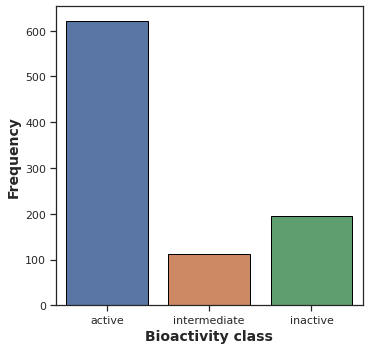

In [49]:
plt.figure(figsize=(5.5, 5.5))
sns.countplot(x='bioactivity_class', data=act_final, edgecolor='black')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
# plt.savefig('plot_bioactivity_class.pdf')

# Making statistical analysis

In [53]:
act_fn = act_final[act_final['bioactivity_class'] != 'intermediate']

In [54]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = act_fn[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = act_fn[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

Text(0, 0.5, 'pIC50 value')

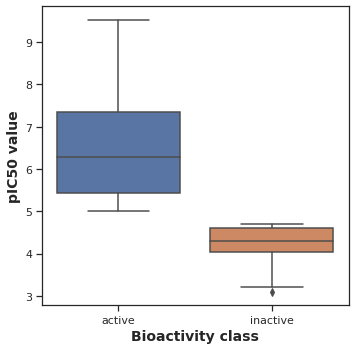

In [55]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

In [56]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,1.106176e-98,0.05,Different distribution (reject H0)


Text(0, 0.5, 'MW value')

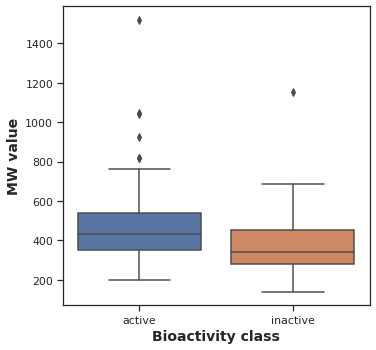

In [57]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW value', fontsize=14, fontweight='bold')

In [58]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,39456.0,1.621755e-13,0.05,Different distribution (reject H0)


Text(0, 0.5, 'NumHDon value')

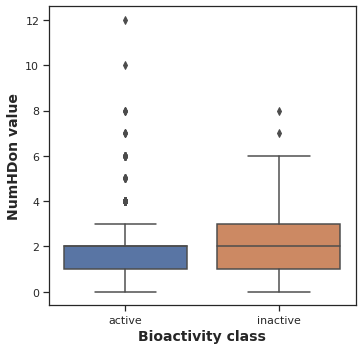

In [59]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDon', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDon value', fontsize=14, fontweight='bold')

In [60]:
mannwhitney('NumHDon')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDon,50581.0,0.000223,0.05,Different distribution (reject H0)


Text(0, 0.5, 'NumHAcc value')

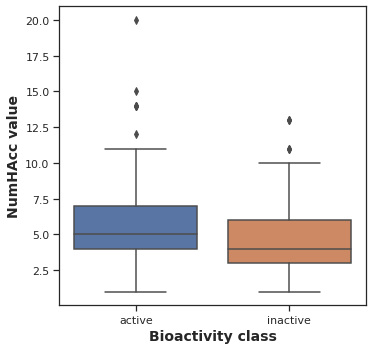

In [61]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcc', data = act_fn)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcc value', fontsize=14, fontweight='bold')

In [62]:
mannwhitney('NumHAcc')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcc,42062.0,4.698254e-11,0.05,Different distribution (reject H0)
